In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 14 23:08:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# To retrieve files/pathnames matching a specified pattern
import glob

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

In [ ]:
# https://www.kaggle.com/kapillondhe/american-sign-language 
TRAIN_DIR = '/content/drive/MyDrive/MMAI/894/team_project/ASL_Dataset/Train'
TEST_DIR = '/content/drive/MyDrive/MMAI/894/team_project/ASL_Dataset/Test'

In [ ]:
# Load all the images under each class (subdirectory)
def load_images(base_dir, directories_as_labels=True, files='**/*.jpg'):
  filenames = glob.glob(os.path.join(base_dir, files))

  # Load all the subdirectories as classes
  classes = (os.path.basename(os.path.dirname(name)) for name in filenames)
  df = pd.DataFrame(list(zip(filenames, classes)), columns=['path', 'label'])

  return df

train_df = load_images(TRAIN_DIR)
test_df = load_images(TEST_DIR)

In [ ]:
batch_size = 128
image_size = 224
num_class = len(train_df['label'].unique())

In [ ]:
# X_training data from a directory
# Sub-directory in that directory will be used as a class for each object
train_datagen = ImageDataGenerator(validation_split=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [ ]:
train_generator = train_datagen.flow_from_directory(
                        directory=TRAIN_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

Found 165829 images belonging to 28 classes.


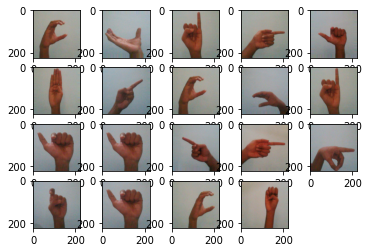

In [ ]:
x_batch, y_batch = train_generator.next()

fig=plt.figure()
columns = 5
rows = 4
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num].astype(np.int32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

### Creating Model from VGG16

**Network Model: VGG16 model architecture**

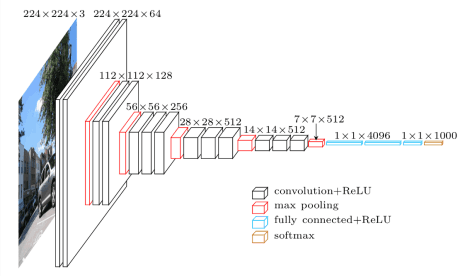

In [ ]:
import keras
from keras.models import Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
# Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Freeze the layers 
base_model.trainable = False

# Create the model
model = keras.models.Sequential()
# Add the vgg convolutional base model
model.add(base_model)

# # Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

# Show a summary of the model.
# Check the number of trainable parameters    
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 28)                28700     
                                                                 
Total params: 41,484,124
Trainable params: 26,769,436
Non-trainable params: 14,714,688
_________________________________________________________________
None


### Training

In [ ]:
# Compile the model
from tensorflow.keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
          optimizer=SGD(learning_rate=1e-3),
          metrics=['accuracy'])

# Start the training process
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n/batch_size,
        epochs=10)

# save the model
model.save('fine_tune.h5')

# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

Epoch 1/10
2591/2591 [==============================] - 80173s 31s/step - loss: 0.0695 - accuracy: 0.9828
Epoch 2/10
2591/2591 [==============================] - 2082s 803ms/step - loss: 0.0042 - accuracy: 0.9991
Epoch 3/10
2591/2591 [==============================] - 2066s 797ms/step - loss: 0.0021 - accuracy: 0.9996
Epoch 4/10
2415/2591 [==========================>...] - ETA: 2:20 - loss: 0.0016 - accuracy: 0.9997

In [ ]:
model.summary

### Testing Our Model

In [ ]:
model = load_model('fine_tune.h5')

test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
                        directory=TRAIN_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

test_generator = test_datagen.flow_from_directory(
                        directory=TEST_DIR, 
                        target_size=(image_size, image_size),
                        color_mode='rgb',
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=1)

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [ ]:
fig=plt.figure()
columns = 4
rows = 4
for i in range(1, columns*rows -1):
    x_batch, y_batch = test_generator.next()

    name = model.predict(x_batch)
    name = np.argmax(name, axis=-1)
    true_name = y_batch
    true_name = np.argmax(true_name, axis=-1)

    label_map = (test_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    predictions = [label_map[k] for k in name]
    true_value = [label_map[k] for k in true_name]

    image = x_batch[0].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.title(str(predictions[0]) + ':' + str(true_value[0]))
    plt.imshow(image)
plt.show()